Authors  
 -  Alonso Guerrero Castaneda (UID: 1194613)  
 -  Eli Gnesin (UID: 1172961)  
 -  Tommy Misikoff (UID: 1166813)  
 -  Sanskriti Purohit (UID: 1179957)  
 -  Will Tirone (UID: 1130904)  

TA: Rick Presman 

### Question 1 {-}

Consider data ${(T_i, \delta_i)}_{i=1}^n$ as data and consider the Kaplan-Meier estimator $\hat{S}_n(t) = \prod_{j:t_j < t}(1 - \frac{d_j}{n_j})$ where $n_j$ are the number of subjects still alive at time $t_j$ and $d_j$ are the number of subjects who died at time $t_j$ and $j$ is the index of observed event times. 

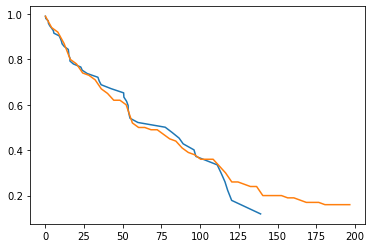

In [1]:
import numpy as np
import numpy.random as nr
from typing import Optional
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import tqdm
import pdb


def streaming_km(
        observed_times: np.ndarray,
        censoring_ind: np.ndarray,
        failure_set: Optional[dict] = {},
        risk_set: Optional[dict] = {}
) -> dict:
    """
    Compute the Kaplan-Meier estimator and sufficient statistics with
    single sweep through the data
    :param observed_times: 1D np.array of observed times, i.e., the
        minimum of failure and censoring times
    :param censoring_ind: 1D np.array of indicators that an observation
        was censored
    :param failure_set: a dictionary mapping failure times to
        the number of observed failures at that time, if None an empty
        dictionary is created.  This allows us to sequentially process
        multiple datasets.  Note that we do not changed passed dictionaries.
    :param risk_set: a dictionary mapping failure times to the
        number of individuals at risk.
    :return: dictionary with key --> value pairs:
        failure_set -> dictionary with keys corresponding to unique failure
            times and values corresponding to number of observed failures at
            that (key) time
        risk_set -> dictionary with keys corresponding to unique failure
            times and values corresponding to number of individuals at risk
            at that (key) time
        km -> dictionary with keys corresponding to unique failure times
            and values corresponding to Kaplan-Meier estimator of
            survivor function.
    """
    
    local_failure_set = failure_set.copy()
    local_risk_set = risk_set.copy()
    # Finding unique values of observed times for which censoring indicator gave the value 1.
    t_unique = np.unique(observed_times[censoring_indicator==1])
    for t in t_unique:
        if t not in local_failure_set:
            local_failure_set[t] = 0.0
        local_failure_set[t] = sum((observed_times==t)&(censoring_ind==1))
        if t not in local_risk_set:
            local_risk_set[t] = 0.0
        local_risk_set[t] += sum(i>=t for i in observed_times)
            

    # Compute KM estimator
    unique_failure_times = np.sort(list(local_failure_set.keys()))
    discrete_hazard = np.array(
        [local_failure_set[j]/local_risk_set[j] for j in unique_failure_times]
    )
    km = np.cumprod(1-discrete_hazard)
    km_dict = dict(zip(unique_failure_times, km))
    return {"failure_set": local_failure_set, "risk_set": local_risk_set,
            "km": km_dict}


if __name__ == "__main__":
    # Generate right-censored data
    nr.seed(1) # for replicability
    n = 100
    true_failure_times = nr.exponential(size=n)*100
    censoring_times = nr.exponential(size=n)*100

    # Note that you could do this in one step rather than two
    observed_times = np.array(
        [min(t, c) for t, c in zip(true_failure_times, censoring_times)]
    )
    censoring_indicator = np.array(
        [t <= c for t, c in zip(true_failure_times, censoring_times)]
    )
    km_est = streaming_km(observed_times, censoring_indicator)
    plt.plot(km_est["km"].keys(), km_est["km"].values())
    ecdf = ECDF(true_failure_times)(
        np.linspace(min(observed_times), max(observed_times))
    )
    plt.plot(np.linspace(min(observed_times), max(observed_times)), 1-ecdf)
    plt.show()

### Question 2 {-}

Consider observed iid data ${(\mathbf{X}_i, Y_i)}_{i=1}^n$ and with $\lambda > 0$, define $(\hat{\mathbf{u}}_n, \hat{\mathbf{v}}_n) = \text{arg min}_{\mathbf{(u,v)}} \mathbb{P}_n \{Y - (\mathbf{u}\circ\mathbf{v})^T\mathbf{X}\}^2 + \lambda||\mathbf{u}||^2/2 + \lambda||\mathbf{v}||^2/2$ with $\hat{\beta}_n^{\lambda} = \hat{\mathbf{u}}_n \circ \hat{\mathbf{v}}_n$. Now, we note that since $\circ$ is the element-wise multiplication of vectors, we can also consider the symbol $/$ to be the element-wise division of vectors, such that $\mathbf{u} = \beta / \mathbf{v}$.

Then:
\begin{aligned}

\end{aligned}

Once we recognize that $\hat{\beta}_n^{\lambda}$ is the LASSO estimator with tuning parameter $\lambda$, we can now consider how to implement a lasso estimator from this representation. First, note that since multiplication is commutative under the real numbers, $\mathbf{u} \circ \mathbf{v} = \begin{pmatrix} u_1 * v_1 & ... & u_p * v_p \end{pmatrix} = \begin{pmatrix} v_1 * u_1 & ... & v_p * u_p \end{pmatrix} = \mathbf{v} \circ \mathbf{u}$, and therefore $(\mathbf{u}\circ\mathbf{v})\mathbf{X} = (\mathbf{v}\circ\mathbf{u})\mathbf{X}$. Now consider the initial definition of the minimization function given above. Consider an initial $\mathbf{v}_0$. Now, we have: 
\begin{aligned}
\hat{\mathbf{u}_1} &= \text{arg min}_{\mathbf{u}} \mathbb{P}_n \{Y - (\mathbf{u}\circ\mathbf{v}_0)^T\mathbf{X}\}^2 + \lambda||\mathbf{u}||^2/2 + \lambda||\mathbf{v}_0||^2/2 \\
&= \text{arg min}_{\mathbf{u}} \mathbb{P}_n \{Y - (\mathbf{u}\circ\mathbf{v}_0)^T\mathbf{X}\}^2 + \lambda||\mathbf{u}||^2/2 + const.
\end{aligned}

Now, we can consider the matrix $\mathbf{X}^*$, defined by taking the elements $v_i$ of $\mathbf{v}_0$ and multiplying $v_i$ by the $i^{th}$ row of $\mathbf{X}$. In this construction, $\mathbf{u}\mathbf{X}^* = (\mathbf{u}\circ\mathbf{v}_0)\mathbf{X}$. Then we have $\hat{\mathbf{u}_1} = \text{arg min}_{\mathbf{u}} \mathbb{P}_n \{Y - \mathbf{u}^T\mathbf{X}^*\}^2 + \lambda||\mathbf{u}||^2/2 + const.$. Now, since we are minimizing with respect to $\mathbf{u}$, and the constant $\lambda||\mathbf{v}_0||^2/2$ does not contain $\mathbf{u}$, we can ignore it with respect to the minimization (since for every $\mathbf{u}$, we would simply be adding on the same extra term). Then, we have $\hat{\mathbf{u}_1} = \text{arg min}_{\mathbf{u}} \mathbb{P}_n \{Y - \mathbf{u}^T\mathbf{X}^*\}^2 + \lambda||\mathbf{u}||^2/2$, which is simply the equation that minimizes to Ridge Regression (with $\lambda/2$ instead of $\lambda$, but we could simply let $\lambda^* = \lambda/2$ to avoid this). As such, we have used this representation to minimize $\mathbf{u}$ given a fixed $\mathbf{v}$ by Ridge Regression.

Now, with $\hat{\mathbf{u}_1}$, consider the matrix $\mathbf{X}^{\circ}$, defined by taking the elements $u_i$ of $\hat{\mathbf{u}_1}$ and multiplying $u_i$ by the $i^{th}$ row of $\mathbf{X}$. With this construction, $\mathbf{v}\mathbf{X}^{\circ} = (\mathbf{v} \circ \hat{\mathbf{u}_1})\mathbf{X}$. Then, we can consider the minimization of $\mathbf{v}$:
\begin{aligned}
\hat{\mathbf{v}_1} &= \text{arg min}_{\mathbf{v}} \mathbb{P}_n \{Y - (\mathbf{v}\circ\hat{\mathbf{u}_1})^T\mathbf{X}\}^2 + \lambda||\hat{\mathbf{u}_1}||^2/2 + \lambda||\mathbf{v}||^2/2 \\
&= \text{arg min}_{\mathbf{v}} \mathbb{P}_n \{Y - \mathbf{v}^T\mathbf{X}^{\circ}\}^2 + \lambda||\mathbf{v}||^2/2 + \lambda||\hat{\mathbf{u}_1}||^2/2
\end{aligned}

Now we have $\hat{\mathbf{v}_1} = \text{arg min}_{\mathbf{v}} \mathbb{P}_n \{Y - \mathbf{v}^T\mathbf{X}^{\circ}\}^2 + \lambda||\mathbf{v}||^2/2 + const.$, and as with the minimization of $\mathbf{u}$ previously, since we are minimizating with respect to $\mathbf{v}$, $\lambda||\hat{\mathbf{u}_1}||^2/2$ is a constant, and so we can ignore it for the sake of minimization, and thus we instead have $\hat{\mathbf{v}_1} = \mathbb{P}_n \{Y - \mathbf{v}^T\mathbf{X}^{\circ}\}^2 + \lambda||\mathbf{v}||^2/2$, which is the equation that minimizes Ridge Regression. As such, we have also minimized $\mathbf{v}$ given $\hat{\mathbf{u}_1}$ by Ridge Regression.

We can now repeat the above process to find $\hat{\mathbf{u}_i}, \hat{\mathbf{v}_i}$ through a series of alternating Ridge Regressions, first minimizing $\mathbf{u}$ using $\hat{\mathbf{v}_{i-1}}$, and then minimizing $\mathbf{v}$ using $\hat{\mathbf{u}_i}$ It is then reasonable to expect that at each iteration $i$, we would then check if $(\hat{\mathbf{u}_i}, \hat{\mathbf{v}_i})$ actually minimizes the original equation, and we would stop when the original equation was minimized (without a closed form, we could do multiple starts of the with different $\mathbf{v}_0$ and accept the best minimized function to give us $(\hat{\mathbf{u}}_n, \hat{\mathbf{v}}_n)$, which can then be used to calculate $\hat{\beta}_n^{\lambda}$. As such, we have shown that, using this representation, we can implement lasso as a sequence of alternating Ridge Regressions using stochastic approximation methods.

It is important to note that the above method does not include any dampening. We could choose to include dampening, within the above framework, by initializing $\mathbf{u}_0, \mathbf{v}_0$ and then, for any iteration $i$, calculating $\mathbf{u}_i = \mathbf{u}_{i-1} + \alpha_i \mathbf{u}^*$ where $\mathbf{u}^*$ is the solution of the minimization with respect to $\mathbf{u}$ using $\mathbf{v}_{i-1}$, and then calculating $\mathbf{v}_i = \mathbf{v}_{i-1} + \alpha_i \mathbf{v}^*$ where $\mathbf{v}^*$ is the solution of the minimization with respect to $\mathbf{v}$ using $\mathbf{u}_i$, with decreasing step sizes $\alpha_i$ that satisfy the conditions $\sum_{i \ge 1} \alpha_i = \infty$ and $\sum_{i \ge 1} \alpha_i^2 < \infty$.

### Resources and Notes {-}